<a href="https://colab.research.google.com/github/PurvanshBarodia/Basic-of-Java-Assignment/blob/main/BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install libraries.
!pip install tensorflow==2.1.0
!pip install tensorflow-probability==0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 421.8 MB 21 kB/s 
     |████████████████████████████████| 3.8 MB 53.8 MB/s 
     |████████████████████████████████| 26.1 MB 1.8 MB/s 
     |████████████████████████████████| 448 kB 54.9 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=a6faff5d4d3f8aacc7b9f676ac1a560574ff698b5864d6b2018eafa41740d992
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      

In [ ]:
# Load libriaries and functions.
import pandas as pd
import numpy as np
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
# Define helper functions.
scaler = StandardScaler()
detector = IsolationForest(n_estimators=1000, contamination="auto", random_state=0) #, behaviour="deprecated"
neg_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [ ]:
# Load data and keep only first six months due to drift.
data = pd.read_excel("data.xlsx")
data = data[data["Date"] <= "2004-09-10"]

In [ ]:
# Select columns and remove rows with missing values.
columns = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH", "CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]
data = data[columns].dropna(axis=0)
# Scale data to zero mean and unit variance.
X_t = scaler.fit_transform(data)
# Remove outliers.
is_inlier = detector.fit_predict(X_t)
X_t = X_t[(is_inlier > 0),:]
# Restore frame.
dataset = pd.DataFrame(X_t, columns=columns)
# Select labels for inputs and outputs.
inputs = ["PT08.S1(CO)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)", "T", "AH"]
outputs = ["CO(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]

In [ ]:
# Define some hyperparameters.
n_epochs = 50
n_samples = dataset.shape[0]
n_batches = 10
batch_size = np.floor(n_samples/n_batches)
buffer_size = n_samples
# Define training and test data sizes.
n_train = int(0.7*dataset.shape[0])
# Define dataset instance.
data = tf.data.Dataset.from_tensor_slices((dataset[inputs].values, dataset[outputs].values))
data = data.shuffle(n_samples, reshuffle_each_iteration=True)
# Define train and test data instances.
data_train = data.take(n_train).batch(batch_size).repeat(n_epochs)
data_test = data.skip(n_train).batch(1)

In [ ]:
# Define prior for regularization.
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(outputs), dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)
# Define model instance.
model = tfk.Sequential([
tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
tfk.layers.Dense(10, activation="relu", name="dense_1"),
tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(
len(outputs)), activation=None, name="distribution_weights"),
tfp.layers.MultivariateNormalTriL(len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches), name="output")
], name="model")
# Compile model.
model.compile(optimizer="adam", loss=neg_log_likelihood)
# Run training session.
model.fit(data_train, epochs=n_epochs, validation_data=data_test, verbose=False)
# Describe model.
model.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                70        
_________________________________________________________________
distribution_weights (Dense) (None, 14)                154       
_________________________________________________________________
output (MultivariateNormalTr ((None, 4), (None, 4))    0         
Total params: 224
Trainable params: 224
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tfp.layers.DenseFlipout(10, activation="relu", name="dense_1")

In [ ]:
# Predict.
samples = 500
iterations = 10
test_iterator = tf.compat.v1.data.make_one_shot_iterator(data_test)
X_true, Y_true, Y_pred = np.empty(shape=(samples, len(inputs))), np.empty(shape=(samples, len(outputs))), np.empty(shape=(samples, len(outputs), iterations))
for i in range(samples):
    features, labels = test_iterator.get_next()
    X_true[i,:] = features
    Y_true[i,:] = labels.numpy()
    for k in range(iterations):
        Y_pred[i,:,k] = model.predict(features)
        
# Calculate mean and standard deviation.
Y_pred_m = np.mean(Y_pred, axis=-1)
Y_pred_s = np.std(Y_pred, axis=-1)

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
dataset = pd.read_csv("PGM_Project/AQI_cleaned.csv")

In [ ]:
dataset['Status'].replace({'Good':1,'Ordinary':2, 'Unhealthy':3,'Unhealthy':4,'Very Unhealthy':5,'Harmful':6},inplace=True)


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2269951 entries, 0 to 2269950
Data columns (total 19 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   County      object 
 2   AQI         float64
 3   Status      int64  
 4   SO2         float64
 5   CO          float64
 6   O3          float64
 7   PM10        float64
 8   PM2.5       float64
 9   NO2         float64
 10  NOx         float64
 11  NO          float64
 12  WindSpeed   float64
 13  WindDirec   float64
 14  PM2.5_AVG   float64
 15  PM10_AVG    float64
 16  SO2_AVG     float64
 17  Longitude   float64
 18  Latitude    float64
dtypes: float64(16), int64(2), object(1)
memory usage: 329.0+ MB


In [ ]:
dataset.dropna(inplace=True)

In [ ]:
x_train = dataset.iloc[:2000000,3:]
y_train = dataset.iloc[:2000000,2:3]

In [ ]:
x_test = dataset.iloc[2000000:,3:]
y_test = dataset.iloc[2000000:,2:3]

In [ ]:
# Define prior for regularization.
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(len(outputs), dtype=tf.float64), scale=1.0), reinterpreted_batch_ndims=1)
# Define model instance.
model = tfk.Sequential([
tfk.layers.InputLayer(input_shape=(len(inputs),), name="input"),
tfk.layers.Dense(10, activation="relu", name="dense_1"),
tfk.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(
len(outputs)), activation=None, name="distribution_weights"),
tfp.layers.MultivariateNormalTriL(len(outputs), activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=1/n_batches), name="output")
], name="model")
# Compile model.
model.compile(optimizer="adam", loss=neg_log_likelihood)
# Run training session.
model.fit(x_train, epochs=n_epochs, validation_data=x_test, verbose=False)
# Describe model.
model.summary()

ValueError: ignored

In [ ]:
#New

In [ ]:
!pip install tensorflow-probability
!pip install tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

In [ ]:
# get train and test dataset
def get_train_and_test_splits(train_size, batch_size=1):
    # We prefetch with a buffer the same size as the dataset because th dataset
    # is very small and fits into memory.
    dataset = (
        tfds.load(name="wine_quality", as_supervised=True, split="train")
        .map(lambda x, y: (x, tf.cast(y, tf.float32)))
        .prefetch(buffer_size=dataset_size)
        .cache()
    )
    # We shuffle with a buffer the same size as the dataset.
    train_dataset = (
        dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size)
    )
    test_dataset = dataset.skip(train_size).batch(batch_size)

    return train_dataset, test_dataset

In [ ]:
def run_experiment(model, loss, train_dataset, test_dataset):

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training the model...")
    model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)
    print("Model training finished.")
    _, rmse = model.evaluate(train_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse = model.evaluate(test_dataset, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")

In [ ]:
#Change
FEATURE_NAMES = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]


def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(1,), dtype=tf.float32
        )
    return inputs

In [ ]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [ ]:
def create_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
dataset_size = 4898
batch_size = 256
train_size = int(dataset_size * 0.85)
train_dataset, test_dataset = get_train_and_test_splits(train_size, batch_size)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/4898 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/wine_quality/white/1.0.0.incompleteAF1NT7/wine_quality-train.tfrecord*...:   0…

Dataset wine_quality downloaded and prepared to ~/tensorflow_datasets/wine_quality/white/1.0.0. Subsequent calls will reuse this data.


In [ ]:
num_epochs = 500
train_sample_size = int(train_size * 0.3)
small_train_dataset = train_dataset.unbatch().take(train_sample_size).batch(batch_size)

bnn_model_small = create_bnn_model(train_sample_size)
run_experiment(bnn_model_small, mse_loss, small_train_dataset, test_dataset)

NameError: ignored

In [ ]:
##################################################

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
%cd gdrive/MyDrive

Mounted at /content/gdrive/
/content/gdrive/MyDrive


In [ ]:
df = pd.read_csv("PGM_Project/AQI_cleaned.csv")
df['Status'].replace({'Good':1,'Ordinary':2, 'Unhealthy':3,'Unhealthy':4,'Very Unhealthy':5,'Harmful':6},inplace=True)

In [ ]:
df.drop(['County'],axis='columns',inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2269951 entries, 0 to 2269950
Data columns (total 18 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   AQI         float64
 2   Status      int64  
 3   SO2         float64
 4   CO          float64
 5   O3          float64
 6   PM10        float64
 7   PM2.5       float64
 8   NO2         float64
 9   NOx         float64
 10  NO          float64
 11  WindSpeed   float64
 12  WindDirec   float64
 13  PM2.5_AVG   float64
 14  PM10_AVG    float64
 15  SO2_AVG     float64
 16  Longitude   float64
 17  Latitude    float64
dtypes: float64(16), int64(2)
memory usage: 311.7 MB


In [ ]:
!pip install torchbnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
df.values

array([[8.66554000e+05, 6.70000000e+01, 2.00000000e+00, ...,
        2.00000000e+00, 1.21760056e+02, 2.51291670e+01],
       [8.66555000e+05, 1.01000000e+02, 4.00000000e+00, ...,
        2.00000000e+00, 1.21640800e+02, 2.50656690e+01],
       [8.66556000e+05, 7.70000000e+01, 2.00000000e+00, ...,
        2.00000000e+00, 1.21689881e+02, 2.51796670e+01],
       ...,
       [3.51780000e+06, 3.70000000e+01, 1.00000000e+00, ...,
        1.00000000e+00, 1.21642300e+02, 2.50671310e+01],
       [3.51780100e+06, 4.40000000e+01, 1.00000000e+00, ...,
        0.00000000e+00, 1.21689881e+02, 2.51796670e+01],
       [3.51780200e+06, 3.50000000e+01, 1.00000000e+00, ...,
        1.00000000e+00, 1.21216350e+02, 2.48638690e+01]])

In [ ]:
k = torch.from_numpy(df.values).float()
print(type(k))

<class 'torch.Tensor'>


In [ ]:
X = df.iloc[:2000, 2:]
Y = df.iloc[:2000, 1:2]

x, y = torch.from_numpy(X.values).float(), torch.tensor(Y['AQI'].values).float()

In [ ]:
y

tensor([ 67., 101.,  77.,  ...,  60.,  84., 137.])

In [ ]:
'''
iris = datasets.load_iris()

X = iris.data
Y = iris.target 

x, y = torch.from_numpy(X).float(), torch.from_numpy(Y).long()
print(x.shape, y.shape)

'''


'\niris = datasets.load_iris()\n\nX = iris.data\nY = iris.target \n\nx, y = torch.from_numpy(X).float(), torch.from_numpy(Y).long()\nprint(x.shape, y.shape)\n\n'

In [ ]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=2000),
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
loss_func = torch.nn.MSELoss()


In [ ]:

for step in range(3000):
    pre = model(x)
    loss = loss_func(pre, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    

    
""" _, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item())) """


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([2000])) that is different to the input size (torch.Size([2000, 2000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


" _, predicted = torch.max(pre.data, 1)\ntotal = y.size(0)\ncorrect = (predicted == y).sum()\nprint('- Accuracy: %f %%' % (100 * float(correct) / total))\nprint('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item())) "

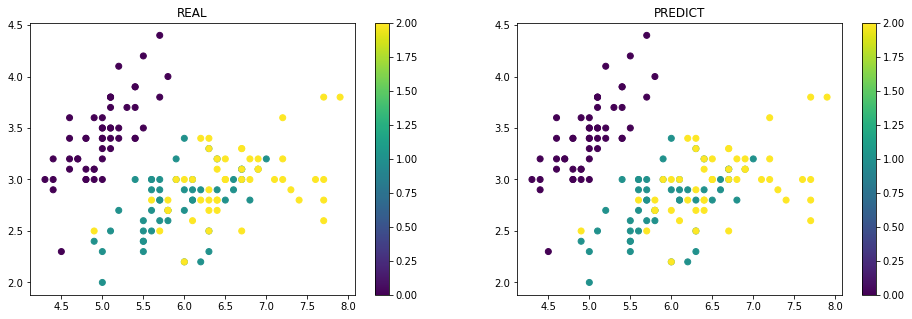

In [ ]:
def draw_plot(predicted) :
    fig = plt.figure(figsize = (16, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    z1_plot = ax1.scatter(X[:, 0], X[:, 1], c = Y)
    z2_plot = ax2.scatter(X[:, 0], X[:, 1], c = predicted)

    plt.colorbar(z1_plot,ax=ax1)
    plt.colorbar(z2_plot,ax=ax2)

    ax1.set_title("REAL")
    ax2.set_title("PREDICT")

    plt.show()

pre = model(x)
_, predicted = torch.max(pre.data, 1)
draw_plot(predicted)
